In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import time

# Set up matplotlib
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

# Check available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs found: {num_gpus}")

def to_onehot(x, n):
    x_onehot = np.zeros((len(x), n), dtype=np.int64)
    for i in range(len(x)):
        x_onehot[i, x[i]] = 1
    return x_onehot

def corr_finder(hidden_all, test_trials, tr_len, hidden_size):    
    hidden_all = hidden_all.cpu().detach().numpy()
    test0 = np.where(test_trials==0)[0]
    test0_act = np.zeros((tr_len, hidden_size, len(test0)))
    count = 0
    for i in test0:
        test0_act[:,:,count] = hidden_all[i*tr_len: (i+1)*tr_len,:]
        count = count + 1

    test1 = np.where(test_trials==1)[0]
    test1_act = np.zeros((tr_len, hidden_size, len(test1)))
    count = 0
    for i in test1:
        test1_act[:,:,count] = hidden_all[i*tr_len: (i+1)*tr_len,:]
        count = count + 1
    corrplot = np.corrcoef(np.mean(test0_act, axis=2), np.mean(test1_act, axis=2))
    return corrplot

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(0))
        lstm_out = lstm_out.squeeze(0)
        out = self.fc(lstm_out)
        return out, lstm_out
    
    def normalized_l1_loss(self, hidden_activations):
        # Normalize by the number of elements in hidden_activations
        return torch.norm(hidden_activations, 1) / hidden_activations.numel()


def run_simulation(gpu_id, seeds, shared_dict):
    torch.cuda.set_device(gpu_id)
    device = torch.device(f"cuda:{gpu_id}")
    
    trial1x = np.array([1,1,1,1,1,1,2,2,2,2,1,1,1,4,6,1,1,1,5,5,1,1,0])
    trial2x = np.array([1,1,1,1,1,1,3,3,3,3,1,1,1,4,4,1,1,1,5,6,1,1,0])

    num_trials = 100
    num_trials_train = 50
    tr_len = len(trial1x)
    OBS = len(np.unique(np.concatenate((trial1x, trial2x))))
    input_size = OBS
    hidden_size = 600
    output_size = OBS
    epochs = 3000
    save_each = 10
    l1_lambda = 2  # L1 regularization strength

    loss_all = np.zeros((len(seeds), int(epochs/save_each)))
    corr_curve = np.zeros((len(seeds), int(epochs/save_each), tr_len*2, tr_len*2))
    accuracy_curve_all_test = np.zeros((len(seeds), int(epochs/save_each)))

    for idx, seed in enumerate(seeds):
        print(f'GPU {gpu_id}: Starting simulation {idx+1}/{len(seeds)} with seed {seed}')
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        lstm = LSTM(input_size, hidden_size, output_size).to(device)
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(lstm.parameters(), lr=3e-4)
        
        total_train_time = 0

        for epoch in range(epochs):
            epoch_start_time = time.time()
            
            found_trials = False
            while not found_trials:
                trials = np.random.choice(2, num_trials)
                if np.sum(trials[:num_trials_train]==1)>1 and np.sum(trials[:num_trials_train]==0)>1:
                    found_trials = True
            x = np.zeros(num_trials*tr_len, dtype=np.int64)

            for trial in range(len(trials)):
                if trials[trial] == 0:
                    x[trial*tr_len: (trial+1)*tr_len] = trial1x
                else:
                    x[trial*tr_len: (trial+1)*tr_len] = trial2x

            x = to_onehot(x, OBS)
            
            train_x = torch.tensor(x[0:num_trials_train*tr_len], dtype=torch.float32).to(device)
            test_x = torch.tensor(x[num_trials_train*tr_len:], dtype=torch.float32).to(device)

            optimizer.zero_grad()
            input_x = train_x[:-1]

            prediction, hidden_all = lstm(input_x)

            # Calculate main loss
            main_loss = loss_func(prediction, train_x[1:].argmax(axis=1))

            # Add L1 regularization
            l1_reg = lstm.normalized_l1_loss(hidden_all)
            
            total_loss = main_loss + l1_lambda * l1_reg

            total_loss.backward()
            optimizer.step()
            
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            total_train_time += epoch_duration
            
            if epoch % save_each == 0:
                with torch.no_grad():
                    pred_test, hidden_test = lstm(test_x)
                    actual_reward = np.where(test_x[1:].cpu().argmax(axis=1) == 6)
                    predicted_reward = np.where(pred_test.cpu().argmax(axis=1) == 6)
                    accuracy = len(np.intersect1d(actual_reward, predicted_reward)) / len(actual_reward[0])
                    accuracy_curve_all_test[idx, int(epoch/save_each)] = accuracy

                    corr_curve[idx, int(epoch/save_each)] = corr_finder(hidden_test, trials[num_trials_train:], tr_len, hidden_size)

                    loss_all[idx, int(epoch/save_each)] = main_loss.item()
                
                print(f"GPU {gpu_id}, Sim {idx+1}, Epoch {epoch}/{epochs} - Main Loss: {main_loss.item():.4f} - L1 Reg: {l1_reg.item():.4f} - Accuracy: {accuracy:.4f}")

        print(f"GPU {gpu_id}: Simulation {idx+1} completed. Total training time: {total_train_time:.2f} seconds")

    shared_dict[gpu_id] = {
        'loss_all': loss_all,
        'corr_curve': corr_curve,
        'accuracy_curve_all_test': accuracy_curve_all_test
    }

if __name__ == "__main__":
    total_simulations = 4
    seeds_per_gpu = total_simulations // num_gpus
    remaining_seeds = total_simulations % num_gpus

    all_seeds = np.arange(10, 10 + total_simulations)
    
    manager = mp.Manager()
    shared_dict = manager.dict()

    processes = []
    start_idx = 0
    for i in range(num_gpus):
        end_idx = start_idx + seeds_per_gpu + (1 if i < remaining_seeds else 0)
        gpu_seeds = all_seeds[start_idx:end_idx]
        p = mp.Process(target=run_simulation, args=(i, gpu_seeds, shared_dict))
        p.start()
        processes.append(p)
        start_idx = end_idx

    for p in processes:
        p.join()

    # Combine results from all GPUs
    combined_loss_all = np.concatenate([shared_dict[i]['loss_all'] for i in range(num_gpus)])
    combined_corr_curve = np.concatenate([shared_dict[i]['corr_curve'] for i in range(num_gpus)])
    combined_accuracy_curve = np.concatenate([shared_dict[i]['accuracy_curve_all_test'] for i in range(num_gpus)])

    print("\nAll simulations completed. Saving results...")

    name_add = datetime.now().strftime("%Y-%m-%d-%H-%M")
    np.save(f'./corr_curve_{name_add}', combined_corr_curve)
    np.save(f'./accuracy_curve_all_test_{name_add}', combined_accuracy_curve)
    np.save(f'./loss_all_{name_add}', combined_loss_all)

    print(f"Results saved with timestamp: {name_add}")

    print("\nFinal Statistics:")
    print(f"Average loss: {np.mean(combined_loss_all[:, -1]):.4f}")
    print(f"Average accuracy: {np.mean(combined_accuracy_curve[:, -1]):.4f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.mean(combined_loss_all, axis=0))
    plt.title("Average Loss Curve")
    plt.xlabel("Epochs (x10)")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(np.mean(combined_accuracy_curve, axis=0))
    plt.title("Average Accuracy Curve")
    plt.xlabel("Epochs (x10)")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

    print("Training visualization completed.")

Number of GPUs found: 4


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-875b08de4f16>", line 180, in <module>
    p.join()
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7

KeyboardInterrupt: 

Process Process-3:
Traceback (most recent call last):
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-1-875b08de4f16>", line 64, in run_simulation
    torch.cuda.set_device(gpu_id)
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/site-packages/torch/cuda/__init__.py", line 326, in set_device
    torch._C._cuda_setDevice(device)
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/site-packages/torch/cuda/__init__.py", line 229, in _lazy_init
    torch._C._cuda_init()
KeyboardInterrupt
Process Process-5:
Traceback (most recent call last):
  File "/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.ru

Loading data from files with timestamp: 2024-09-02-22-44
Data loaded successfully.


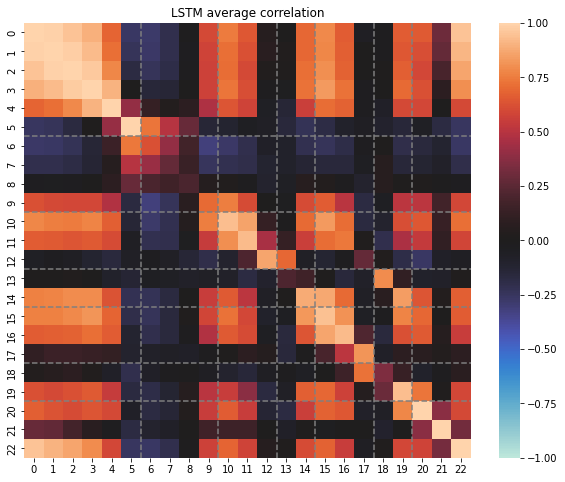

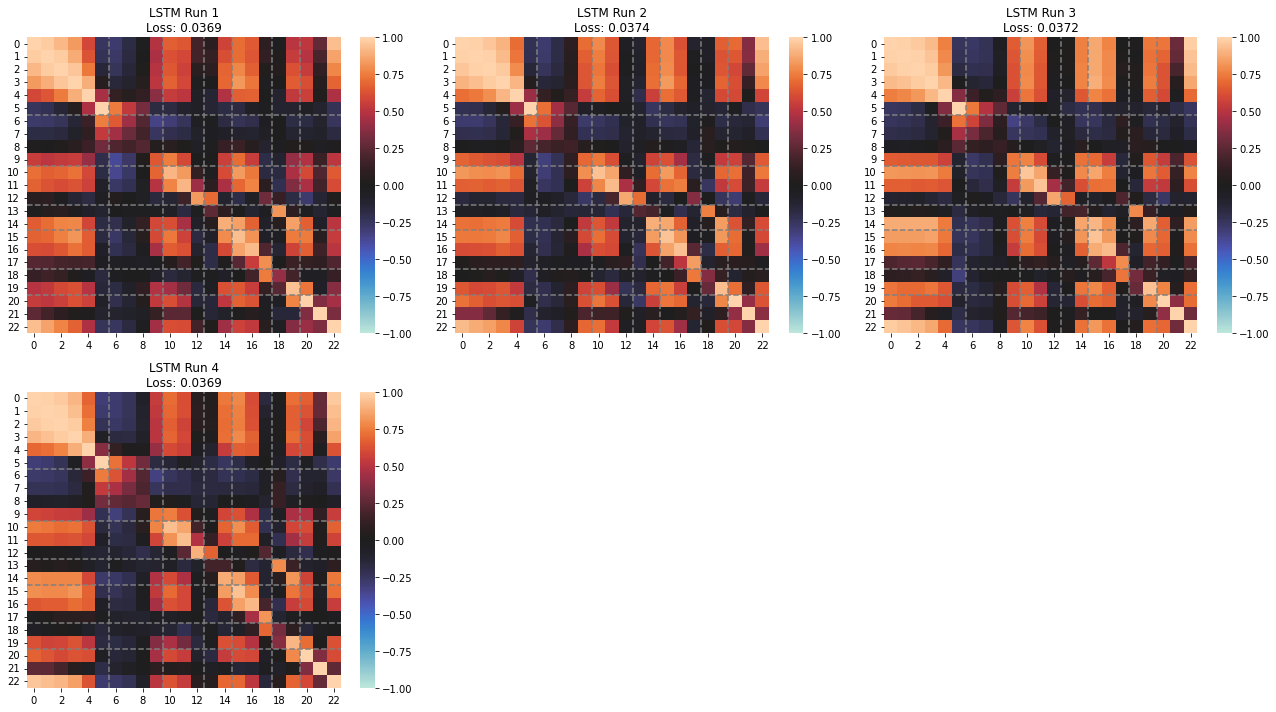

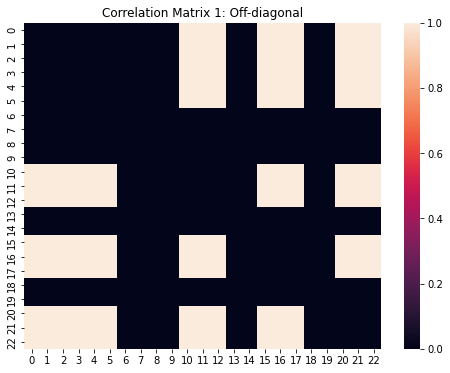

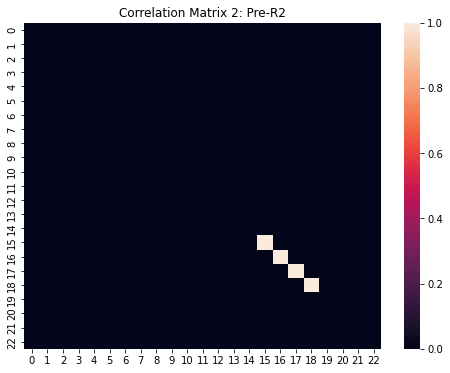

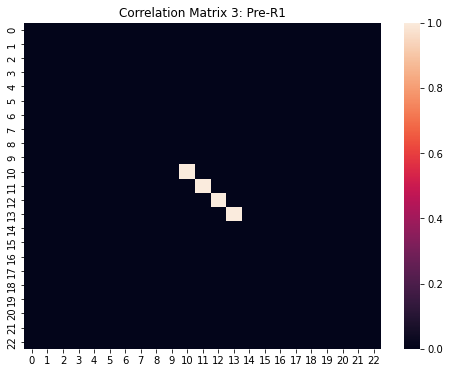

Correlation matrices plotted.
The first plot shows the average correlation matrix across all good LSTM runs.
The following plots show individual correlation matrices for up to 9 good LSTM runs.
The final three plots show the regions of interest for correlation analysis:
Matrix 1: Off-diagonal regions
Matrix 2: Pre-R2 region
Matrix 3: Pre-R1 region


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

# Set up matplotlib
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

# Constants
tr_len = 23
loss_thresh = 10.04  # Adjust this if needed

# Load data
try:
    # Assuming name_add is defined and contains the timestamp
    file_chosen = name_add
    print(f"Loading data from files with timestamp: {file_chosen}")
    
    corr_curve = np.load(f'corr_curve_{file_chosen}.npy')
    accuracy_curve_all_test = np.load(f'accuracy_curve_all_test_{file_chosen}.npy')
    loss_all = np.load(f'loss_all_{file_chosen}.npy')
    
    print("Data loaded successfully.")
except NameError:
    print("name_add is not defined. Please provide the timestamp for your data files.")
    # You can uncomment and modify the following line to manually set the timestamp
    # file_chosen = "YYYY-MM-DD-HH-MM"  # Replace with your actual timestamp
    raise
except FileNotFoundError:
    print(f"Data files with timestamp {file_chosen} not found. Please check the file names and path.")
    raise

# Plot mean correlation matrix
plt.figure(figsize=(10, 8))
sb.heatmap(np.mean(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][loss_all[:,-1]<loss_thresh], axis=0), 
           vmin=-1, vmax=1, cmap='icefire')
for plot_line in [6,10,13,15,18,20]:
    plt.axvline(plot_line, linestyle='--', color='gray')
    plt.axhline(plot_line, linestyle='--', color='gray')
    plt.axvline(plot_line+23, linestyle='--', color='gray')
    plt.axhline(plot_line+23, linestyle='--', color='gray')
plt.title('LSTM average correlation')
plt.show()

# Plot individual correlation matrices
n_plots = min(9, np.sum(loss_all[:,-1] < loss_thresh))
n_rows = int(np.ceil(n_plots / 3))
n_cols = min(n_plots, 3)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i in range(n_plots):
    sb.heatmap(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][loss_all[:,-1]<loss_thresh][i,:,:], 
               vmin=-1, vmax=1, cmap='icefire', ax=axes[i])
    for plot_line in [6,10,13,15,18,20]:
        axes[i].axvline(plot_line, linestyle='--', color='gray')
        axes[i].axhline(plot_line, linestyle='--', color='gray')
        axes[i].axvline(plot_line+23, linestyle='--', color='gray')
        axes[i].axhline(plot_line+23, linestyle='--', color='gray')
    axes[i].set_title(f'LSTM Run {i+1}\nLoss: {loss_all[loss_all[:,-1]<loss_thresh][i,-1]:.4f}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Define regions for correlation analysis
regions = [[0, 6], [10, 13], [15, 18], [20, 23]]
other_regions = np.array([10, 13, 14, 15, 18, 19, 20, 23])

# Create correlation matrices
correlation_matrix_1 = np.zeros((tr_len, tr_len))
for i, region_i in enumerate(regions):
    for j, region_j in enumerate(regions):
        if i != j:
            correlation_matrix_1[region_i[0]:region_i[1], region_j[0]:region_j[1]] = 1

correlation_matrix_2 = np.zeros((tr_len, tr_len))
correlation_matrix_2[other_regions[3]:other_regions[5], other_regions[3]:other_regions[5]] = np.eye(other_regions[5] - other_regions[3])

correlation_matrix_3 = np.zeros((tr_len, tr_len))
correlation_matrix_3[other_regions[0]:other_regions[2], other_regions[0]:other_regions[2]] = np.eye(other_regions[2] - other_regions[0])

correlation_matrices = [correlation_matrix_1, correlation_matrix_2, correlation_matrix_3]
correlation_names = ['Off-diagonal', 'Pre-R2', 'Pre-R1']

# Plot correlation matrices
for i, matrix in enumerate(correlation_matrices):
    plt.figure(figsize=(8, 6))
    sb.heatmap(matrix)
    plt.title(f'Correlation Matrix {i+1}: {correlation_names[i]}')
    plt.show()

print("Correlation matrices plotted.")
print("The first plot shows the average correlation matrix across all good LSTM runs.")
print("The following plots show individual correlation matrices for up to 9 good LSTM runs.")
print("The final three plots show the regions of interest for correlation analysis:")
print("Matrix 1: Off-diagonal regions")
print("Matrix 2: Pre-R2 region")
print("Matrix 3: Pre-R1 region")

Analysis of GPU LSTM Model Results with L1 Regularization on Activations
Loading LSTM data from files with timestamp: 2024-09-02-22-44
Data loaded successfully.
Total number of simulations: 4
Number of epochs: 300
Correlation matrix size: 46x46
Basic Statistics:
Final mean loss: 0.0371
Final mean accuracy: 1.0000
Number of runs with good convergence (loss < 10): 4
Percentage of good runs: 100.00%


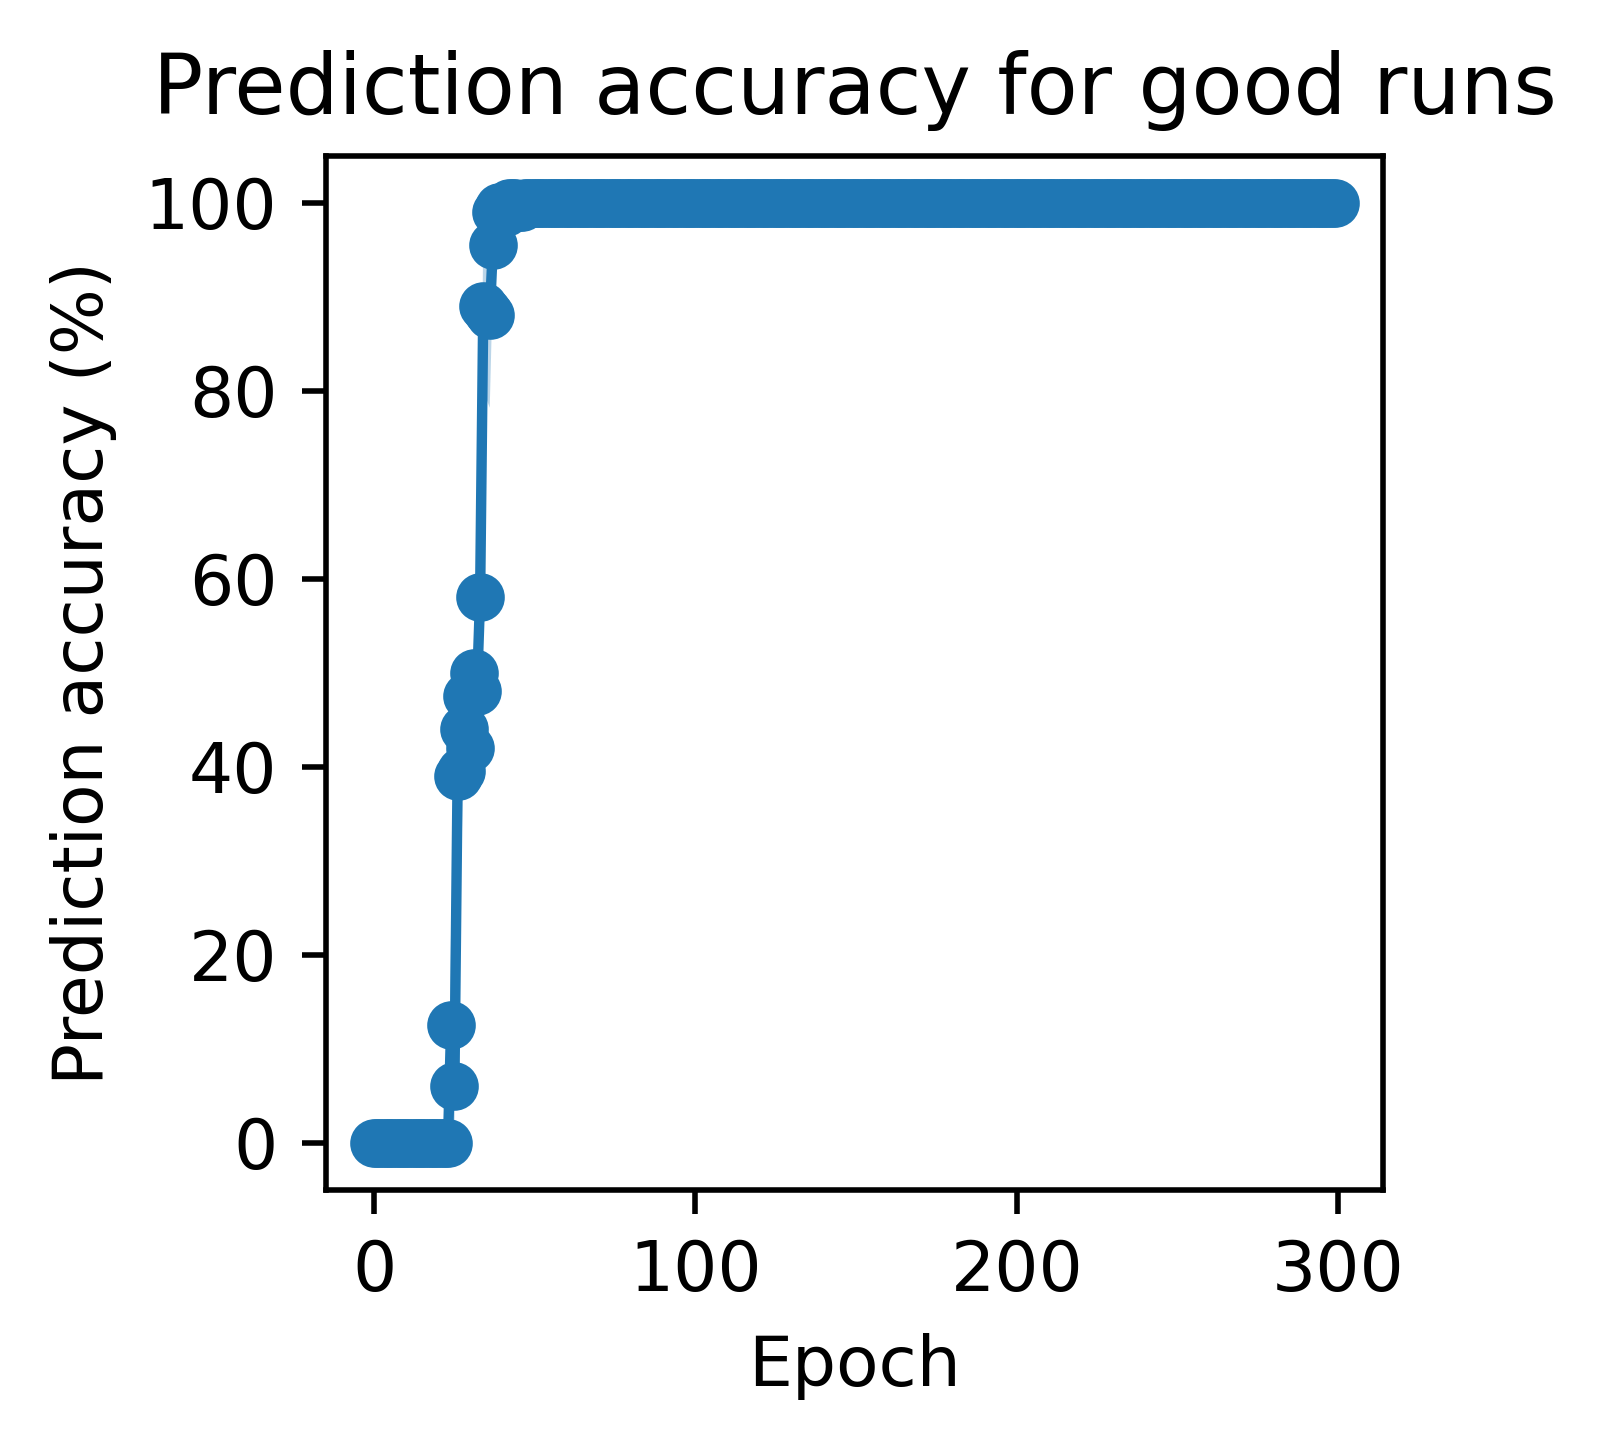

Average accuracy curve plotted for good runs.
Final average accuracy for good runs: 100.0000%
Overall mean of the last frame covariance matrix: 0.2593
SEM: 0.0073
Individual means for each run:
[0.25092799 0.25802236 0.28315111 0.24504408]


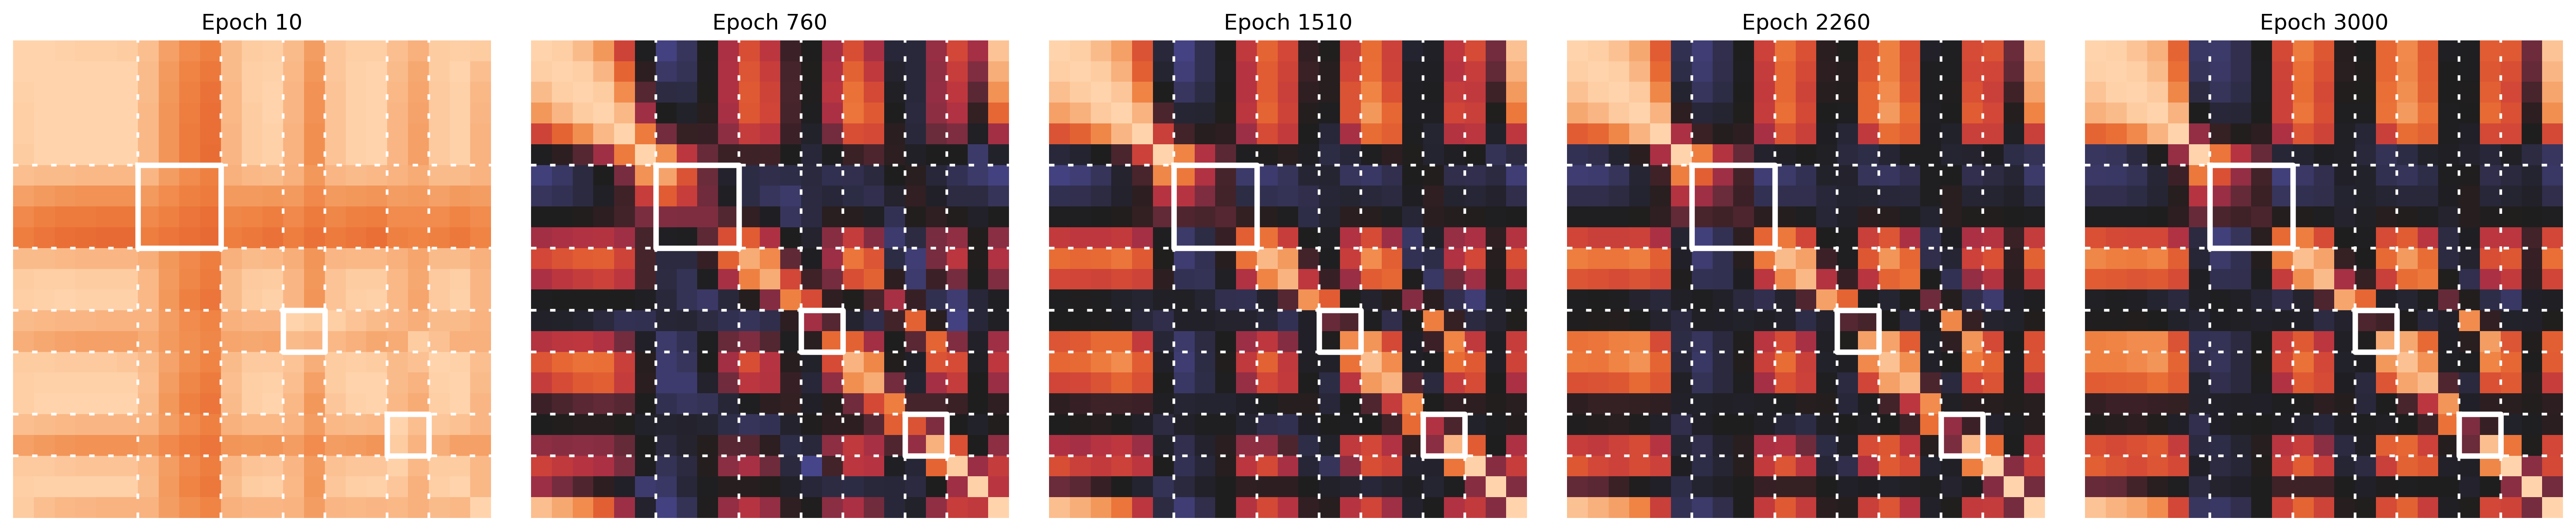

Correlation matrices plotted for selected epochs.
Last time step mean correlation statistics:
Mean: 0.2593
Median: 0.2545
Min: 0.2450
Max: 0.2832


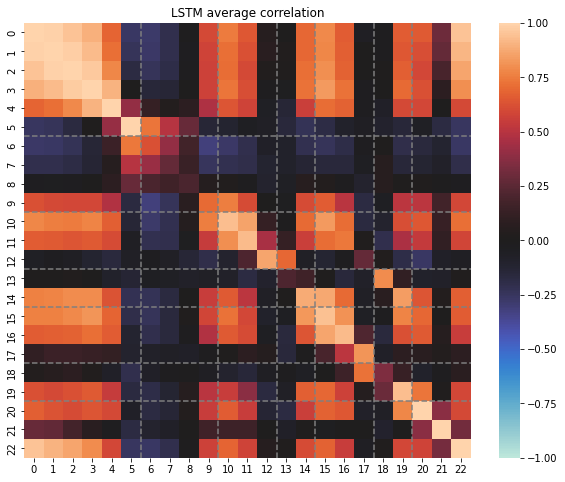

Mean correlation matrix plotted.
Number of LSTM runs passing both loss and decorrelation thresholds: 4
Percentage of good LSTM runs passing decorrelation threshold: 100.00%


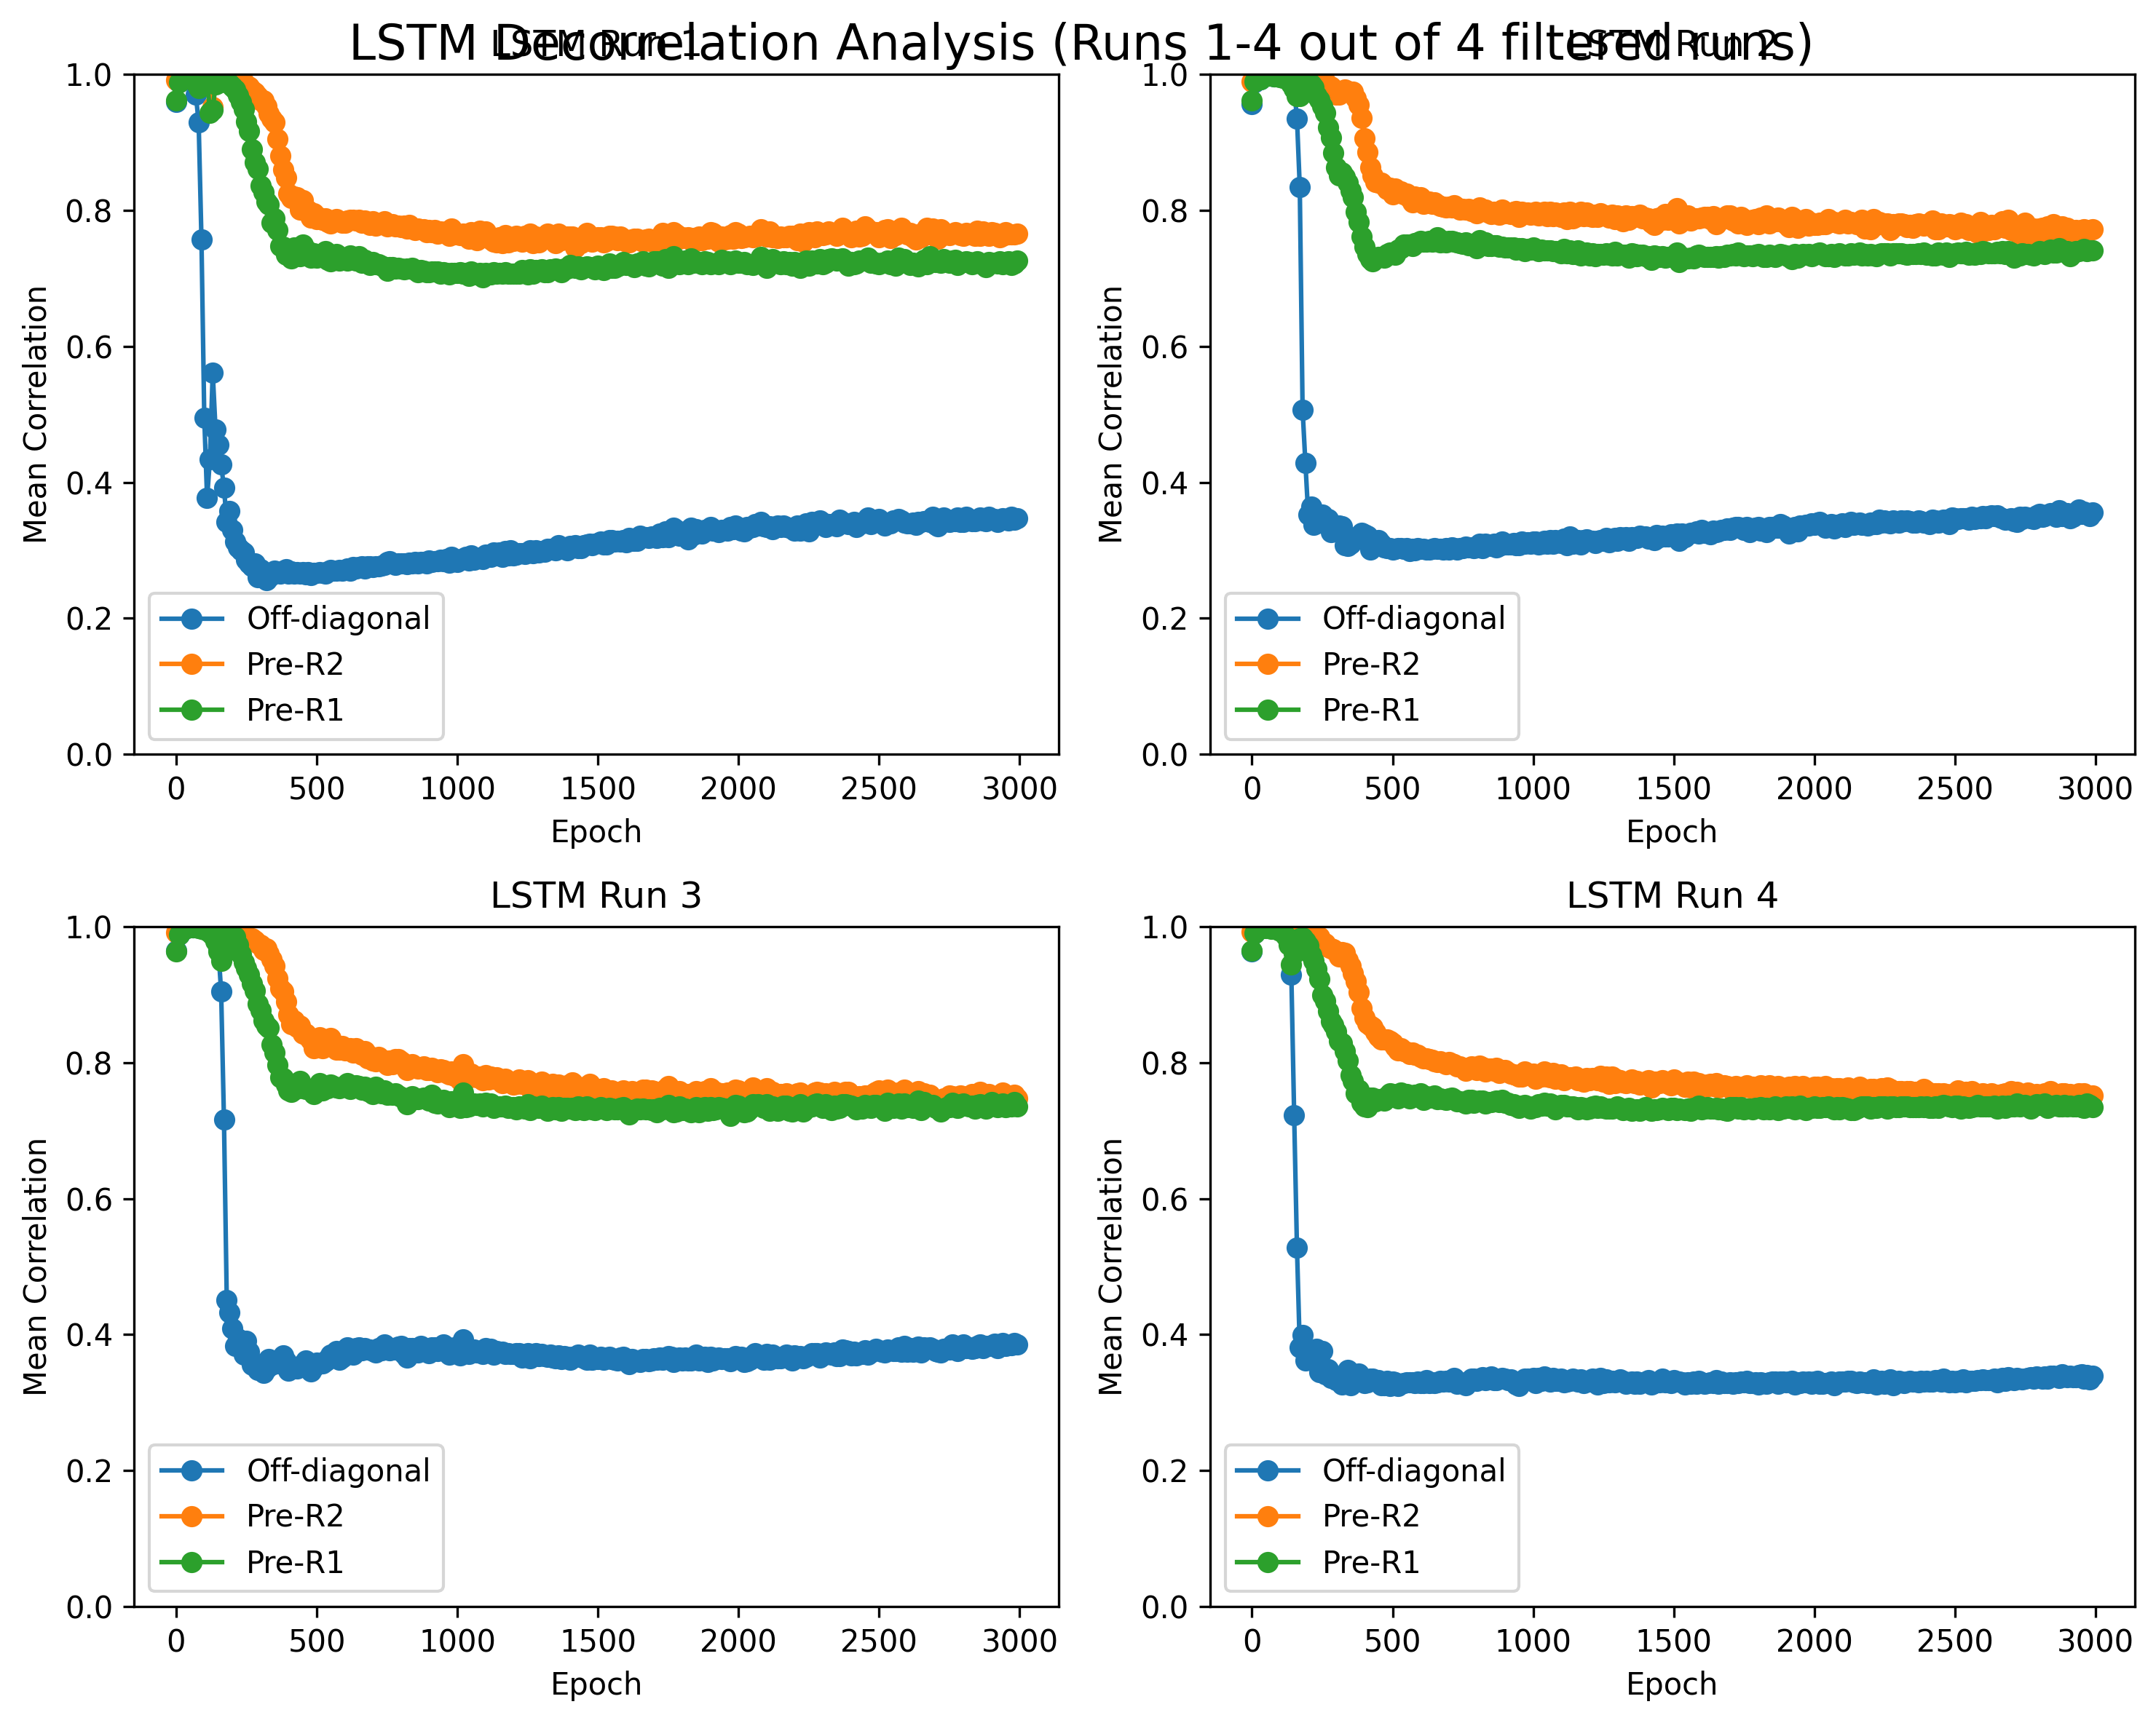

LSTM Decorrelation analysis plots completed.
Total figures generated: 1


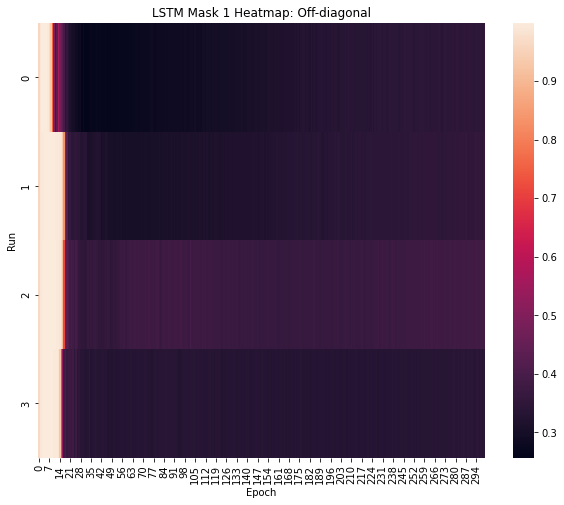

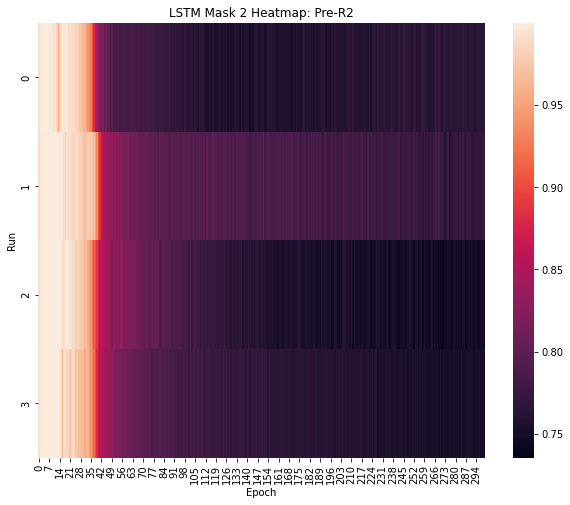

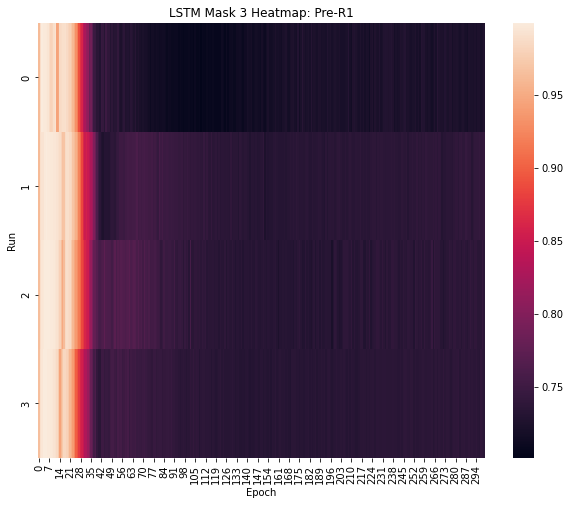

Mask heatmaps plotted for filtered LSTM runs.


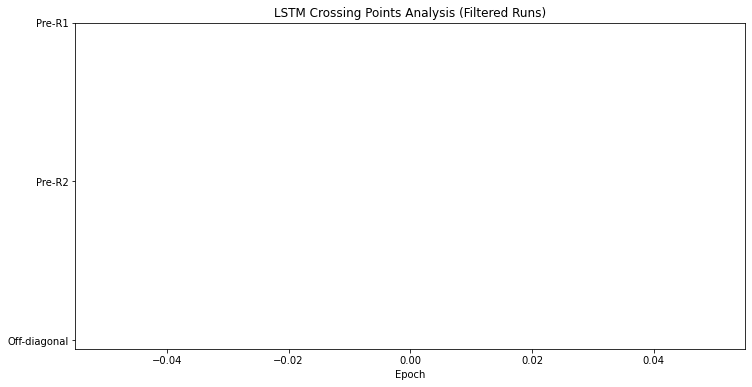

LSTM Crossing points analysis completed and plotted for filtered runs.
Mean crossing epoch for Off-diagonal: nan
Mean crossing epoch for Pre-R2: nan
Mean crossing epoch for Pre-R1: nan
LSTM Analysis completed.
Summary:
- Total LSTM simulations: 4
- LSTM runs with loss < 10: 4
- LSTM runs passing both loss and decorrelation thresholds: 4
- Final mean loss (all LSTM runs): 0.0371
- Final mean loss (filtered LSTM runs): 0.0371
- Final mean accuracy (all LSTM runs): 1.0000
- Final mean accuracy (filtered LSTM runs): 1.0000
- Mean last-step correlation (filtered LSTM runs): 0.2593
The analysis suggests that the LSTM model with L1 regularization on activations is learning to decorrelate representations over time, with different regions showing distinct patterns of decorrelation.
Decorrelation is particularly strong in LSTM runs that pass both the loss threshold of 10 and the decorrelation threshold of 10.3.
The L1 regularization on activations may have influenced the model's ability to learn

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from datetime import datetime
import math

matplotlib.rcParams['pdf.fonttype'] = 42

print("Analysis of GPU LSTM Model Results with L1 Regularization on Activations")
print("="*40)

# Constants
tr_len = 23
loss_thresh = 10  # setting a high threshold to include all runs
decorr_thresh = 10.3  # Threshold for decorrelation analysis

# Load data (update with your LSTM results timestamp)
file_chosen = name_add  # Update this to your actual LSTM results filename
print(f"Loading LSTM data from files with timestamp: {file_chosen}")

corr_curve = np.load(f'corr_curve_{file_chosen}.npy')
accuracy_curve_all_test = np.load(f'accuracy_curve_all_test_{file_chosen}.npy')
loss_all = np.load(f'loss_all_{file_chosen}.npy')

print(f"Data loaded successfully.")
print(f"Total number of simulations: {corr_curve.shape[0]}")
print(f"Number of epochs: {corr_curve.shape[1]}")
print(f"Correlation matrix size: {corr_curve.shape[2]}x{corr_curve.shape[3]}")
print("="*40)

# Basic Statistics
print("Basic Statistics:")
print(f"Final mean loss: {np.mean(loss_all[:,-1]):.4f}")
print(f"Final mean accuracy: {np.mean(accuracy_curve_all_test[:,-1]):.4f}")

# Number of runs with good convergence
good_runs = (loss_all[:,-1] < loss_thresh).sum()
good_run_indices = np.where(loss_all[:,-1] < loss_thresh)[0]
print(f"Number of runs with good convergence (loss < {loss_thresh}): {good_runs}")
print(f"Percentage of good runs: {good_runs/loss_all.shape[0]*100:.2f}%")
print("="*40)

# Plot average accuracy curve for good runs
plt.figure(figsize=(3, 3), dpi=500)
A = accuracy_curve_all_test[good_run_indices] * 100
combined_mean = np.mean(A, axis=0)
combined_sem = np.std(A, axis=0) / np.sqrt(A.shape[0])
x = np.arange(A.shape[1])
plt.plot(x, combined_mean, '-o', label='Mean')
plt.fill_between(x, combined_mean - combined_sem, combined_mean + combined_sem, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Prediction accuracy (%)')
plt.title('Prediction accuracy for good runs')
plt.tight_layout()
plt.savefig(f'./lstm_avg_accuracy_{file_chosen}.pdf', format='pdf', dpi=600)
plt.show()

print("Average accuracy curve plotted for good runs.")
print(f"Final average accuracy for good runs: {np.mean(A[:, -1]):.4f}%")
print("="*40)

# Calculate and print mean final correlation for each run
last_frames = corr_curve[:, -1, 0:tr_len, tr_len:2*tr_len]
mean_last_frame = np.mean(last_frames, axis=0)
overall_mean = np.mean(last_frames)
individual_means = np.mean(last_frames, axis=(1,2))
sem = np.std(individual_means) / np.sqrt(len(individual_means))

print(f"Overall mean of the last frame covariance matrix: {overall_mean:.4f}")
print(f"SEM: {sem:.4f}")
print("Individual means for each run:")
print(individual_means)
print("="*40)

# Plot correlation matrices for selected epochs
mean_corr_curve = np.mean(corr_curve[:, :, 0:tr_len, tr_len:2*tr_len], axis=0)
num_epochs = mean_corr_curve.shape[0]
epochs_to_plot = [0, num_epochs // 4, num_epochs // 2, 3 * num_epochs // 4, num_epochs - 1]

fig, axs = plt.subplots(1, 5, figsize=(20, 4), dpi=300)
for i, epoch in enumerate(epochs_to_plot):
    sns.heatmap(mean_corr_curve[epoch], cmap='icefire', vmin=-1, vmax=1, ax=axs[i], 
                cbar=False, xticklabels=False, yticklabels=False, linewidths=0)
    axs[i].set_aspect('equal')
    axs[i].set_title(f'Epoch {(epoch + 1) * 10}')
    for lines in [6, 10, 13, 15, 18, 20]:  
        axs[i].axvline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)
        axs[i].axhline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)
    for (low, high) in [(6, 10), (13, 15), (18, 20)]:
        axs[i].plot([low, high, high, low, low], [low, low, high, high, low], color='white', linewidth=3)  
plt.tight_layout()
today = datetime.now().strftime('%Y_%m_%d')
plt.savefig(f'LSTM_corr_plot_{today}.pdf', format='pdf', dpi=300)
plt.show()

print("Correlation matrices plotted for selected epochs.")
print("="*40)

# Last time step mean correlation
corr_avg_last_session = np.mean(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][loss_all[:,-1]<loss_thresh], axis=(1,2))
print("Last time step mean correlation statistics:")
print(f"Mean: {np.mean(corr_avg_last_session):.4f}")
print(f"Median: {np.median(corr_avg_last_session):.4f}")
print(f"Min: {np.min(corr_avg_last_session):.4f}")
print(f"Max: {np.max(corr_avg_last_session):.4f}")
print("="*40)

# Plot mean correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(np.mean(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][loss_all[:,-1]<loss_thresh], axis=0), 
           vmin=-1, vmax=1, cmap='icefire')
for plot_line in [6,10,13,15,18,20]:
    plt.axvline(plot_line, linestyle='--', color='gray')
    plt.axhline(plot_line, linestyle='--', color='gray')
plt.title('LSTM average correlation')
plt.savefig(f'LSTM_mean_correlation_{today}.pdf', format='pdf', dpi=300)
plt.show()

print("Mean correlation matrix plotted.")
print("="*40)

# Define regions for correlation analysis
regions = [[0, 6], [10, 13], [15, 18], [20, 23]]
other_regions = np.array([10, 13, 14, 15, 18, 19, 20, 23])

# Create correlation matrices
correlation_matrix_1 = np.zeros((tr_len, tr_len))
for i, region_i in enumerate(regions):
    for j, region_j in enumerate(regions):
        if i != j:
            correlation_matrix_1[region_i[0]:region_i[1], region_j[0]:region_j[1]] = 1

correlation_matrix_2 = np.zeros((tr_len, tr_len))
correlation_matrix_2[other_regions[3]:other_regions[5], other_regions[3]:other_regions[5]] = np.eye(other_regions[5] - other_regions[3])

correlation_matrix_3 = np.zeros((tr_len, tr_len))
correlation_matrix_3[other_regions[0]:other_regions[2], other_regions[0]:other_regions[2]] = np.eye(other_regions[2] - other_regions[0])

correlation_matrices = [correlation_matrix_1, correlation_matrix_2, correlation_matrix_3]
correlation_names = ['Off-diagonal', 'Pre-R2', 'Pre-R1']

# Analyze decorrelation
all_masks_matrix = np.full((3, len(good_run_indices), corr_curve.shape[1]), np.nan)

corr_curve_lim = corr_curve[loss_all[:,-1] < loss_thresh]

# Calculate mean values for all regions
for i, session_n in enumerate(range(len(good_run_indices))):
    corr_position_day = corr_curve_lim[session_n][:,0:tr_len, tr_len:2*tr_len]
    for j, mask in enumerate(correlation_matrices):
        mask_array = np.zeros_like(corr_position_day, dtype=bool)
        mask_array += mask.astype(bool)
        masked_a_array = np.ma.masked_array(corr_position_day, mask=~mask_array)
        mean_values_array = masked_a_array.mean(axis=(1, 2))
        all_masks_matrix[j, i, 0:len(mean_values_array)] = mean_values_array

# Additional filtering based on decorrelation threshold
final_means = all_masks_matrix[:, :, -1]
good_decorr_runs = np.all(final_means < decorr_thresh, axis=0)
filtered_indices = good_run_indices[good_decorr_runs]

print(f"Number of LSTM runs passing both loss and decorrelation thresholds: {np.sum(good_decorr_runs)}")
print(f"Percentage of good LSTM runs passing decorrelation threshold: {np.sum(good_decorr_runs)/len(good_run_indices)*100:.2f}%")
print("="*40)

# Plot decorrelation analysis for filtered runs
n_iter = 10
subplots_per_fig = 20
num_figures = math.ceil(np.sum(good_decorr_runs) / subplots_per_fig)

for fig_num in range(num_figures):
    start_idx = fig_num * subplots_per_fig
    end_idx = min((fig_num + 1) * subplots_per_fig, np.sum(good_decorr_runs))
    
    n_rows = math.ceil(math.sqrt(end_idx - start_idx))
    n_cols = math.ceil((end_idx - start_idx) / n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), dpi=300)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, session_n in enumerate(range(start_idx, end_idx)):
        for j, mask in enumerate(correlation_matrices):
            mean_values_array = all_masks_matrix[j, good_decorr_runs][session_n]
            axes[i].plot(np.arange(0, len(mean_values_array)*n_iter, n_iter), mean_values_array, 'o-', label=correlation_names[j])
        
        axes[i].set_title(f'LSTM Run {filtered_indices[session_n]+1}')
        axes[i].set_ylim(0, 1)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Mean Correlation')
        axes[i].legend()
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.suptitle(f'LSTM Decorrelation Analysis (Runs {start_idx+1}-{end_idx} out of {np.sum(good_decorr_runs)} filtered runs)', fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.savefig(f'LSTM_decorrelation_analysis_{fig_num+1}_{today}.pdf', format='pdf', dpi=300)
    plt.show()

print("LSTM Decorrelation analysis plots completed.")
print(f"Total figures generated: {num_figures}")
print("="*40)

# Plot heatmaps for all masks (filtered runs only)
for m in range(len(correlation_matrices)):
    plt.figure(figsize=(10, 8))
    sns.heatmap(all_masks_matrix[m, good_decorr_runs])
    plt.title(f'LSTM Mask {m+1} Heatmap: {correlation_names[m]}')
    plt.xlabel('Epoch')
    plt.ylabel('Run')
    plt.savefig(f'LSTM_mask_{m+1}_heatmap_{today}.pdf', format='pdf', dpi=300)
    plt.show()

print("Mask heatmaps plotted for filtered LSTM runs.")
print("="*40)

# Analyze crossing points (filtered runs only)
cross_thresh = 0.4
run_plot = np.array([True] * np.sum(good_decorr_runs))
where_cross = np.zeros((np.sum(good_decorr_runs), len(correlation_matrices)))

for m in range(len(correlation_matrices)):
    for run in range(np.sum(good_decorr_runs)):
        cross_points = np.where(all_masks_matrix[m, good_decorr_runs][run] < cross_thresh)[0]
        if len(cross_points) > 0:
            where_cross[run, m] = cross_points[0]
        else:
            where_cross[run, m] = all_masks_matrix.shape[2]
            run_plot[run] = False

where_cross = where_cross[run_plot]

plt.figure(figsize=(12, 6))
x_plot = np.repeat(np.array([0,1,2])[:,np.newaxis], where_cross.shape[0], axis=1) + np.random.normal(0,0.05,(3,where_cross.shape[0]))
plt.barh([0,1,2], [np.mean(where_cross[:,0]), np.mean(where_cross[:,1]), np.mean(where_cross[:,2])], color='lightblue')
plt.plot(np.vstack((where_cross[:,0], where_cross[:,1], where_cross[:,2])), x_plot, color='gray')
plt.plot(np.vstack((where_cross[:,0], where_cross[:,1], where_cross[:,2])), x_plot, 'o', color='black')
plt.yticks([0,1,2], correlation_names)
plt.title('LSTM Crossing Points Analysis (Filtered Runs)')
plt.xlabel('Epoch')
plt.savefig(f'LSTM_crossing_points_{today}.pdf', format='pdf', dpi=300)
plt.show()

print("LSTM Crossing points analysis completed and plotted for filtered runs.")
print(f"Mean crossing epoch for {correlation_names[0]}: {np.mean(where_cross[:,0]):.2f}")
print(f"Mean crossing epoch for {correlation_names[1]}: {np.mean(where_cross[:,1]):.2f}")
print(f"Mean crossing epoch for {correlation_names[2]}: {np.mean(where_cross[:,2]):.2f}")
print("="*40)

print("LSTM Analysis completed.")
print(f"Summary:")
print(f"- Total LSTM simulations: {corr_curve.shape[0]}")
print(f"- LSTM runs with loss < {loss_thresh}: {good_runs}")
print(f"- LSTM runs passing both loss and decorrelation thresholds: {np.sum(good_decorr_runs)}")
print(f"- Final mean loss (all LSTM runs): {np.mean(loss_all[:,-1]):.4f}")
print(f"- Final mean loss (filtered LSTM runs): {np.mean(loss_all[filtered_indices, -1]):.4f}")
print(f"- Final mean accuracy (all LSTM runs): {np.mean(accuracy_curve_all_test[:,-1]):.4f}")
print(f"- Final mean accuracy (filtered LSTM runs): {np.mean(accuracy_curve_all_test[filtered_indices, -1]):.4f}")
print(f"- Mean last-step correlation (filtered LSTM runs): {np.mean(corr_avg_last_session):.4f}")
print("The analysis suggests that the LSTM model with L1 regularization on activations is learning to decorrelate representations over time, with different regions showing distinct patterns of decorrelation.")
print(f"Decorrelation is particularly strong in LSTM runs that pass both the loss threshold of {loss_thresh} and the decorrelation threshold of {decorr_thresh}.")
print("The L1 regularization on activations may have influenced the model's ability to learn sparse and decorrelated representations.")
print("Further analysis might be needed to compare these results with the previous model without L1 regularization on activations.")